In [208]:
import sqlite3
import pandas as pd


db_path = '/Users/neo/Projects/temple/malasim/build/bin/monthly_data_0.db'

conn = sqlite3.connect(db_path)

# Query to sum treatments and treatmentfailures grouped by monthly_data_id
query = '''
select * from main.monthly_site_data_district;
'''

# Creating a cursor object to interact with the database
cur = conn.cursor()
cur.execute(query)
monthly_data = cur.fetchall()

monthly_data_df = pd.DataFrame(monthly_data)
monthly_data_df.columns = [col[0] for col in cur.description]

In [209]:
for col in monthly_data_df.columns:
    print(f"{col}")

monthly_data_id
unit_id
population
clinical_episodes
clinical_episodes_by_age_class_0_1
clinical_episodes_by_age_class_1_2
clinical_episodes_by_age_class_2_3
clinical_episodes_by_age_class_3_4
clinical_episodes_by_age_class_4_5
clinical_episodes_by_age_class_5_6
clinical_episodes_by_age_class_6_7
clinical_episodes_by_age_class_7_8
clinical_episodes_by_age_class_8_9
clinical_episodes_by_age_class_9_10
clinical_episodes_by_age_class_10_11
clinical_episodes_by_age_class_11_15
clinical_episodes_by_age_class_15_20
clinical_episodes_by_age_class_20_60
clinical_episodes_by_age_class_60_100
clinical_episodes_by_age_0
clinical_episodes_by_age_1
clinical_episodes_by_age_2
clinical_episodes_by_age_3
clinical_episodes_by_age_4
clinical_episodes_by_age_5
clinical_episodes_by_age_6
clinical_episodes_by_age_7
clinical_episodes_by_age_8
clinical_episodes_by_age_9
clinical_episodes_by_age_10
clinical_episodes_by_age_11
clinical_episodes_by_age_12
clinical_episodes_by_age_13
clinical_episodes_by_age_14


In [210]:
last_month_df = monthly_data_df[-1:].copy()
print(f"Pfpr: {last_month_df['pfpr_2to10'].values[0]}")
treatment_per_1000_pop = last_month_df['treatments'].values[0] * 12 / last_month_df['population'].values[0] * 1000
print(f"Treatment per 1000 pop: {treatment_per_1000_pop}")
print(f"Population: {last_month_df['population'].values[0]}")
print(f"Clinical episodes: {last_month_df['clinical_episodes'].values[0]}")
print(f"Total treatments: {last_month_df['treatments'].values[0]}")
print(f"Pfpr 2 to 10: {last_month_df['pfpr_2to10'].values[0]}")
print(f"Treatment failures: {last_month_df['treatment_failures'].values[0]}")
print(f"EIR (annual): {last_month_df['eir'].values[0]}")

Pfpr: 11.491517617256468
Treatment per 1000 pop: 231.85637891520244
Population: 62832
Clinical episodes: 1736
Total treatments: 1214
Pfpr 2 to 10: 11.491517617256468
Treatment failures: 63
EIR (annual): 7.562771478306138


In [211]:
last_year_df = monthly_data_df[-12:].copy()
treatments_per_1000 = last_year_df['treatments'].sum() / last_year_df['population'].median() * 1000
clinical_episodes_per_1000 = last_year_df['clinical_episodes'].sum() / last_year_df['population'].median() * 1000
print(f"Total treatments per 1000 pop in last year: {treatments_per_1000}")
print(f"Total clinical episodes per 1000 pop in last year: {clinical_episodes_per_1000}")

Total treatments per 1000 pop in last year: 210.54831966554107
Total clinical episodes per 1000 pop in last year: 307.34844830358577


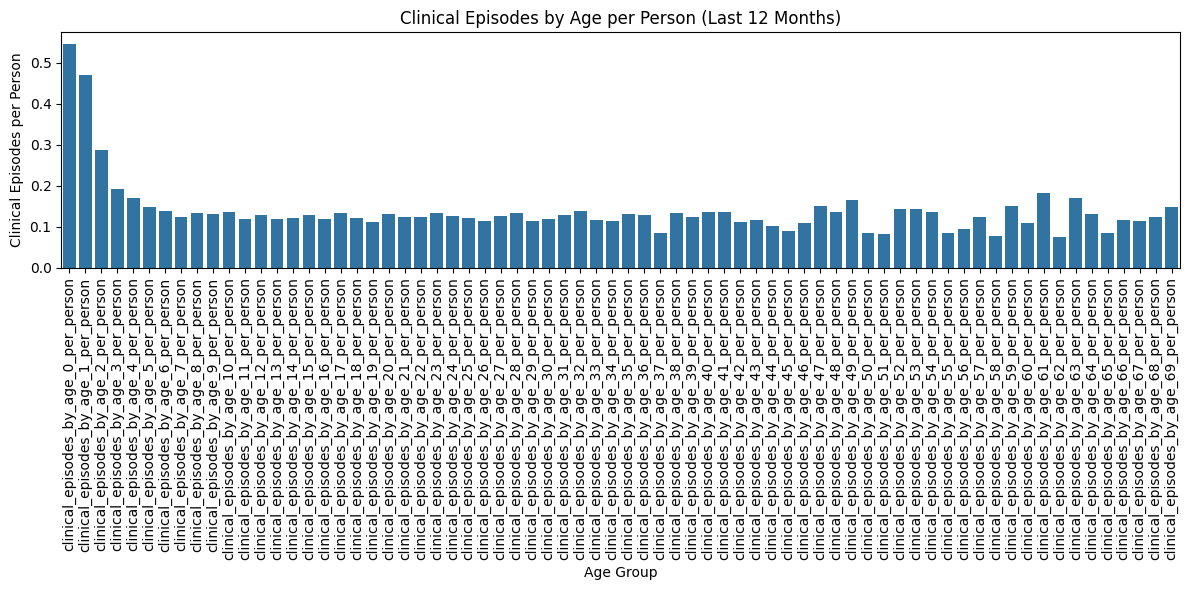

In [212]:
## clinical_episodes_by_age_n / population_by_age_n
for age in range(0,70):
    # clinical episodes by age per person
    p = monthly_data_df[f'clinical_episodes_by_age_{age}'] / monthly_data_df[f'population_by_age_{age}']
    monthly_data_df[f'clinical_episodes_by_age_{age}_per_person'] = p

# extracting the relevant columns
columns_of_interest = [ f'clinical_episodes_by_age_{age}_per_person' for age in range(0,70) ]
clinical_episodes_by_age_df = monthly_data_df[columns_of_interest]
# get last 12 months of data
clinical_episodes_by_age_df = clinical_episodes_by_age_df.tail(12)
# sum to get 1 year
clinical_episodes_by_age_df = clinical_episodes_by_age_df.sum()

# plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=clinical_episodes_by_age_df.index, y=clinical_episodes_by_age_df.values)
plt.title('Clinical Episodes by Age per Person (Last 12 Months)')
plt.xlabel('Age Group')
plt.ylabel('Clinical Episodes per Person')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

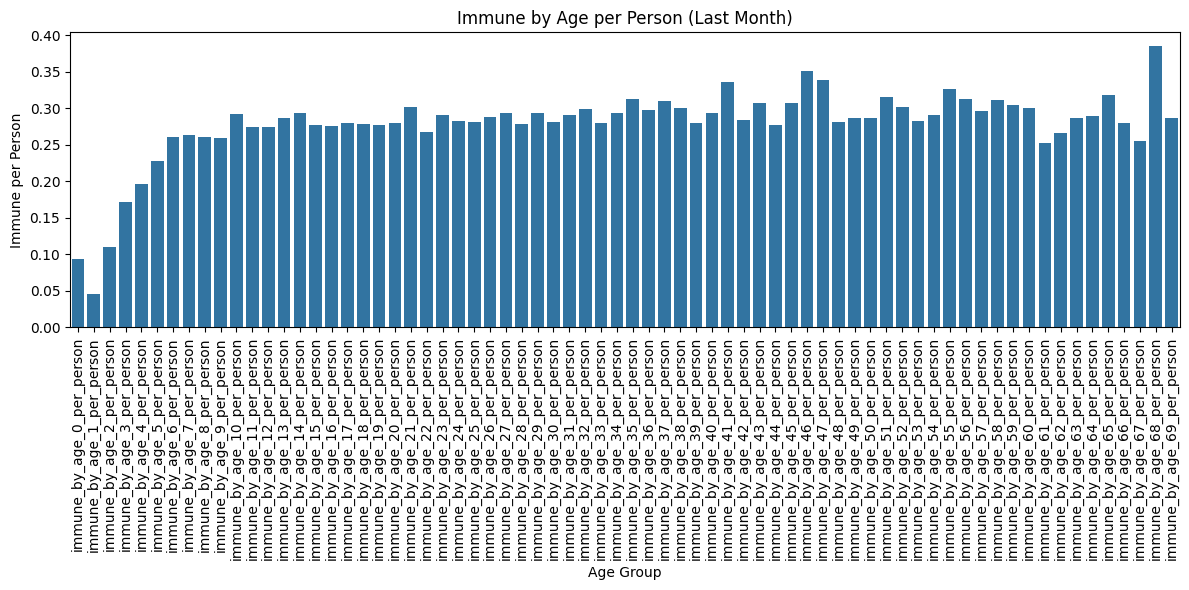

In [213]:
## clinical_episodes_by_age_n / population_by_age_n

# Create all new columns at once using pd.concat
immune_columns = {}
for age in range(0, 70):
    # clinical episodes by age per person
    p = monthly_data_df[f'total_immune_by_age_{age}'] / monthly_data_df[f'population_by_age_{age}']
    immune_columns[f'immune_by_age_{age}_per_person'] = p

# Create a new DataFrame with all the new columns and concat with original
immune_df = pd.DataFrame(immune_columns, index=monthly_data_df.index)
monthly_data_df = pd.concat([monthly_data_df, immune_df], axis=1)

# extracting the relevant columns
columns_of_interest = [f'immune_by_age_{age}_per_person' for age in range(0, 70)]
immune_by_age_df = monthly_data_df[columns_of_interest]
# get the very last month of data
immune_by_age_df = immune_by_age_df.tail(1)

plt.figure(figsize=(12, 6))
sns.barplot(x=immune_by_age_df.columns, y=immune_by_age_df.values.flatten())
plt.title('Immune by Age per Person (Last Month)')
plt.xlabel('Age Group')
plt.ylabel('Immune per Person')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

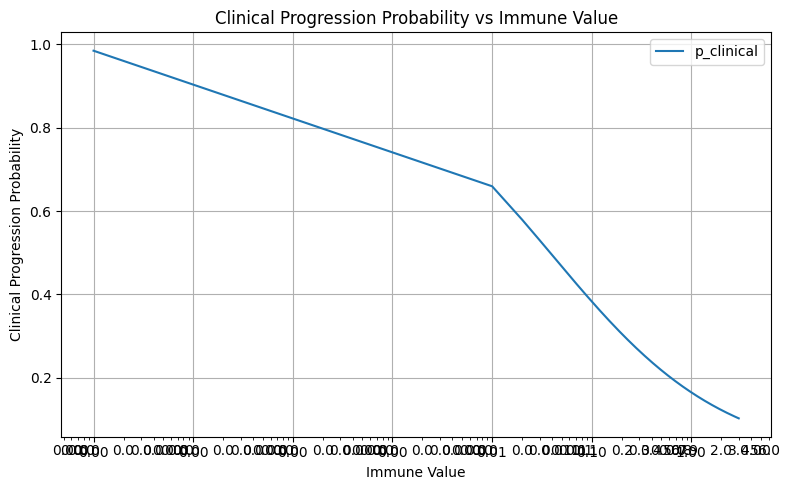

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Constants from the code and assumed based on typical sigmoid function
MID_POINT = 0.04 # This can be adjusted as per actual implementation
isf_max_clinical_probability = 0.99
isf_immune_effect_on_progression_to_clinical = 0.5

# Define the function
def p_clinical(immune):
    return isf_max_clinical_probability / (
        1 + np.power((immune / MID_POINT), isf_immune_effect_on_progression_to_clinical)
    )

# Generate a range of immune values
immune_values = np.linspace(0.000001, 3, 300)
p_clinical_values = p_clinical(immune_values)

# Plot the function

plt.figure(figsize=(8, 5))
plt.plot(immune_values, p_clinical_values, label='p_clinical')
plt.title('Clinical Progression Probability vs Immune Value')
plt.xlabel('Immune Value')
plt.ylabel('Clinical Progression Probability')
#log y
plt.xscale('log')
# show number in scientific notation
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().xaxis.set_minor_formatter(plt.ScalarFormatter())

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


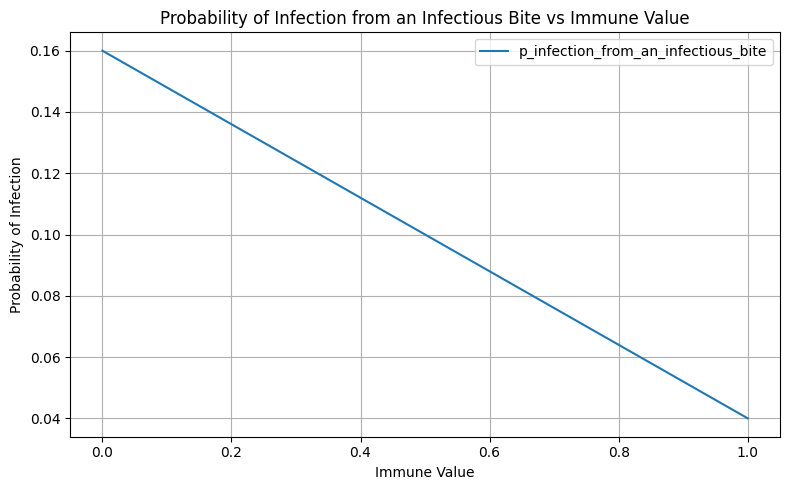

In [215]:
# Plotting the p_infection_from_an_infectious_bite function

immune_values = np.linspace(0, 1, 200)
p_infection = ((1 - immune_values) / 8.333) + 0.04

plt.figure(figsize=(8, 5))
plt.plot(immune_values, p_infection, label='p_infection_from_an_infectious_bite')
plt.title('Probability of Infection from an Infectious Bite vs Immune Value')
plt.xlabel('Immune Value')
plt.ylabel('Probability of Infection')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [216]:
simulation_acquisition_rate_by_age = [
	0.000508863, 0.000632749, 0.000786795, 0.000897451, 0.000988129, 0.00106711, 0.00113837, 0.00120417, 0.00126593, 0.00132457,
	0.00138078, 0.00139459, 0.00140853, 0.00142262, 0.00143684, 0.00145121, 0.00146572, 0.00148038, 0.00149518, 0.00151014,
	0.00152524, 0.00154049, 0.00155589, 0.00157145, 0.00158717, 0.00160304, 0.00161907, 0.00163526, 0.00165161, 0.00166813,
	0.00168481, 0.00170166, 0.00171868, 0.00173586, 0.00175322, 0.00177075, 0.00178846, 0.00180635, 0.00182441, 0.00184265,
	0.00186108, 0.00187969, 0.00189849, 0.00191747, 0.00193665, 0.00195601, 0.00197557, 0.00199533, 0.00201528, 0.00203544,
	0.00205579, 0.00207635, 0.00209711, 0.00211808, 0.00213926, 0.00216066, 0.00218226, 0.00220408, 0.00222613, 0.00224839,
	0.00227087, 0.00229358, 0.00231652, 0.00233968, 0.00236308, 0.00238671, 0.00241058, 0.00243468, 0.00245903, 0.00248362,
	0.00250845, 0.00253354, 0.00255887, 0.00258446, 0.00261031, 0.00263641, 0.00266277, 0.0026894, 0.0027163, 0.00274346,
	0.00277089
]

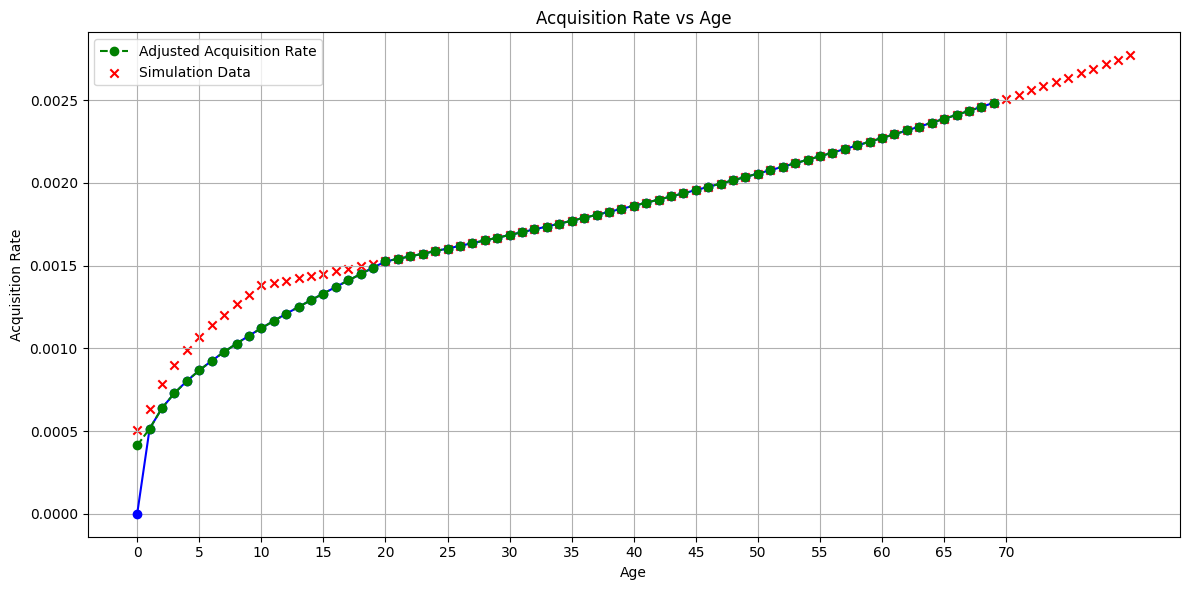

In [217]:
kappa = 0.3
immune_inflation = 0.01

base_acquisition_rate = 0.00125

age_mature_immunity = 20

# for age < 10
# acquisition_rate = (a/10)^kappa x (1+immune_inflation)^age * base_acquisition_rate
# for age > 10
# acquisition_rate = (1+immune_inflation)^ (age-10) * 0.0013809

age = [i for i in range(0, 70)]
acquisition_rates = []
for a in age:
    if a <= age_mature_immunity:
        acquisition_rate = ((a / age_mature_immunity)) ** kappa * ((1+immune_inflation) ** a) * base_acquisition_rate
    else:
        acquisition_rate = ((1+immune_inflation) ** (a - age_mature_immunity)) * (1 + immune_inflation) **age_mature_immunity * base_acquisition_rate
    acquisition_rates.append(acquisition_rate)

acquisition_rates2 = []
acr = base_acquisition_rate
for a in age:
    factor = 1
    if a <= age_mature_immunity:
        factor = 0.5 if a ==0 else a
        factor = factor / age_mature_immunity
        factor = factor ** kappa

    acquisition_rate = factor * acr
    acquisition_rates2.append(acquisition_rate)
    acr *= (1 + immune_inflation)


plt.figure(figsize=(12, 6))
plt.plot(age, acquisition_rates, marker='o', linestyle='-', color='b')
plt.plot(age, acquisition_rates2, marker='o', linestyle='--', color='g', label='Adjusted Acquisition Rate')
plt.scatter(range(0,81), simulation_acquisition_rate_by_age, marker='x', color='r', label='Simulation Data')
plt.legend()
plt.title('Acquisition Rate vs Age')
plt.xlabel('Age')
plt.ylabel('Acquisition Rate')
plt.grid(True)
plt.xticks(range(0, 71, 5))
plt.tight_layout()
plt.show()